# Classification Models

Darts provides a comprehensive set of classification models for time series forecasting tasks. These models can predict categorical labels or class probabilities for future time steps based on historical data and optional covariates. The classification models in Darts include:

- **SKLearnClassifierModel**: A wrapper around any scikit-learn-like classifier (default: Logistic Regression)
- **XGBClassifierModel**: Wrapper around XGBoost's XGBClassifier
- **LightGBMClassifierModel**: Wrapper around LightGBM's LGBMClassifier with native categorical feature support  
- **CatBoostClassifierModel**: Wrapper around CatBoost's CatBoostClassifier with native categorical feature support

This notebook demonstrates how to use Darts' classification models for time series labeling tasks, where we predict categorical labels for each time step based on recent behavior patterns. 

*Note: The labeling task shown here is purely for demonstration purposes to showcase the classification capabilities of Darts' forecasting models. Since we artificially generate the labels using the same patterns that we later use as features, this is not meant to demonstrate model performance or predictive accuracy.*

We'll show how to:

1. Generate synthetic time series data with categorical labels
2. Create and train a classification model using features derived from the time series
3. Apply the trained model to label new time series data
4. Evaluate model performance using classification metrics
5. Generate probabilistic forecasts with class probabilities

Note: In the final section, we'll explain how these classification models can also be used for traditional forecasting tasks (predicting future categorical values) using the same workflow as regression models, but with classification instead of regression as the underlying task.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd

import darts.utils.timeseries_generation as tg
from darts import TimeSeries, metrics
from darts.models import CatBoostClassifierModel

We generate a synthetic time series with trend, seasonality and noise. The frequency is hourly with a 24 hour seasonality.

<Axes: xlabel='time'>

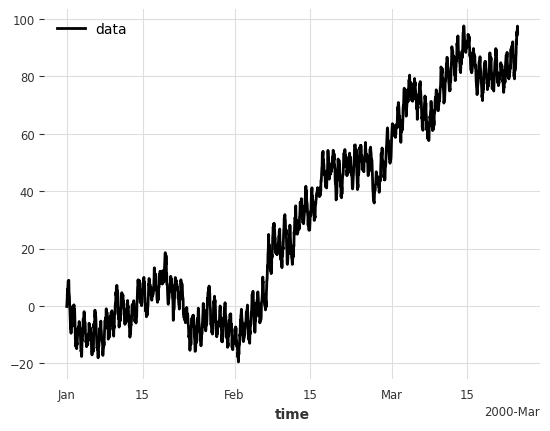

In [3]:
np.random.seed(42)
n_points = 2000

kwargs = {"freq": "h", "length": n_points, "column_name": "data"}
# Generate a time series with trend, seasonality, and noise
trend = tg.random_walk_timeseries(**kwargs)
seasonality = tg.sine_timeseries(value_amplitude=5.0, value_frequency=1 / 24, **kwargs)
noise = tg.gaussian_timeseries(**kwargs)

series = trend + seasonality + noise
series.plot()

Now we generate categorical labels based on the recent behavior of the time series. We'll create four different categories based on the volatility (standard deviation) and trend direction over a 24-hour window. This simulates a real-world scenario where we want to classify the current state of a system based on its recent performance.

**Important**: The labels generated here are artificially created using the same patterns that we'll later use as features. This is done purely for demonstration purposes to show how Darts' classification models work. In a real-world scenario, you would have actual categorical labels that you want to predict based on time series features.

<Axes: xlabel='time'>

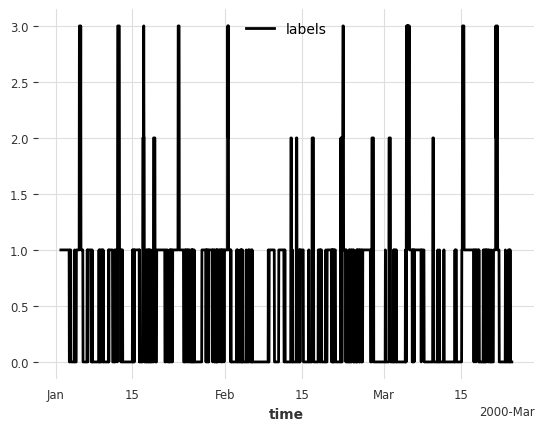

In [4]:
# Generate labels based on recent behavior (last 24 hours)
cats = {
    "high std, trend inc": 0,
    "high std, trend dec": 1,
    "low std, trend inc": 2,
    "low std, trend dec": 3,
}
window = 24
series_vals = series.values(copy=False)

labels = []
for i in range(n_points):
    if i < window - 1:  # Not enough history for first 24 hours
        labels.append(np.nan)  # Default to normal
    else:
        # Calculate features based on recent behavior
        recent_values = series_vals[i - (window - 1) : i + 1]
        recent_std = np.std(recent_values, ddof=1)
        recent_trend = recent_values[-1] - recent_values[0]

        # Define labels based on recent behavior
        if recent_std >= 2.5:  # High volatility
            if recent_trend >= 0:  # Increasing trend
                labels.append(cats["high std, trend inc"])
            else:
                labels.append(cats["high std, trend dec"])
        else:
            if recent_trend >= 0:
                labels.append(cats["low std, trend inc"])
            else:
                labels.append(cats["low std, trend dec"])

labels = TimeSeries.from_times_and_values(
    times=series.time_index, values=labels, columns=["labels"]
).strip()

labels.plot()

Next, we create features from the time series that will be used as input to our classification model. We compute rolling statistics (standard deviation and trend) over 24-hour windows to capture the same patterns that were used to generate the labels. These features will serve as our future covariates, allowing the model to learn the relationship between the time series behavior and the corresponding categorical labels.

**Note**: Since we're using the same patterns for both label generation and feature creation, the model will naturally perform very well on this artificial example. This is intentional for demonstration purposes.

<Axes: xlabel='time'>

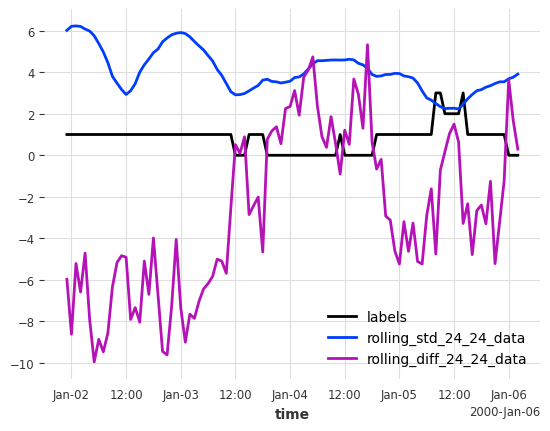

In [5]:
# get rolling std and trend over 24 hour windows
window_kwargs = {"window": window, "mode": "rolling", "min_periods": window}
features = series.window_transform(
    transforms=[
        {"function": "std", **window_kwargs},  # rolling std
        {
            "function": lambda x: x[-1] - x[0],
            "function_name": "diff",
            **window_kwargs,
        },  # rolling trend
    ],
    keep_non_transformed=False,
    treat_na="dropna",
)

labels[:100].plot()
features[:100].plot()

We split our data into training, validation, and test sets. The training set will be used to fit the model, the validation set for early stopping (and optional hyperparameter tuning), and the test set for final evaluation. This ensures we can properly assess the model's generalization performance.

In [6]:
labels_train, labels_val, labels_test = labels[:1000], labels[1000:1500], labels[1500:]

### Classification Models

Now we create and fit one of Darts' classifier models. For convenience, Darts ships with a couple of classification models: 

- **SKLearnClassifierModel**: wrap the Darts Model API around any sklearn-like classifier model (default: Logistic Regression)
- **XGBClassifierModel**: wrapper around XGBoost’s XGBClassifier
- **LightGBMClassifierModel**: wrapper around LightGBM’s LightGBMClassifier
- **CatBoostClassifierModel**: wrapper around CatBoost’s CatBoostClassifier

Let's use `CatBoostClassifierModel` and make it use the features at time `t` to predict the label at time `t`. To do this, simply set `lags_future_covariates=[0]`.

For more information on lags and Darts' SKLearn-like models, check out [this example notebook](https://unit8co.github.io/darts/examples/20-SKLearnModel-examples.html).

In [7]:
model = CatBoostClassifierModel(lags_future_covariates=[0])
model.fit(
    series=labels_train,
    future_covariates=features,
    val_series=labels_val,
    val_future_covariates=features,
)

CatBoostClassifierModel(lags=None, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=classprobability, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

### Time Series Labeling

Great! Now we can apply the pre-trained model to label the entire test set using `historical_forecasts` with `retrain=False`.

<Axes: xlabel='time'>

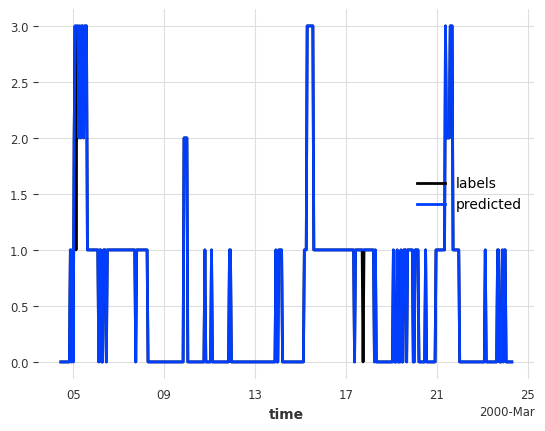

In [8]:
# label the test set
hfc_kwargs = {
    "series": labels_test,
    "future_covariates": features,
    "retrain": False,
    "last_points_only": True,
}
preds = model.historical_forecasts(**hfc_kwargs)

# and plot the predictions against actuals
labels_test.plot()
preds.plot(label="predicted")

From a first glance, this looks great.

### Classification Metrics and Evaluation

Let's evaluate the performance. We compute the backtest using Darts' built-in metrics for classification. You can find all classification metrics [here](https://unit8co.github.io/darts/generated_api/darts.metrics.html) in the "Classification Metrics" section.

**Note**: The high performance metrics you'll see are expected since we artificially created labels using the same patterns as our features. This demonstrates that the classification models work correctly, but it's not representative of real-world performance where the relationship between features and labels is more complex and unknown.

Check out the metrics' [documentation](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.f1) for more information about how to extract label-specific metrics, customize aggregation methods, and more.

In [9]:
model.backtest(
    historical_forecasts=preds,
    metric=[
        metrics.accuracy,
        metrics.precision,
        metrics.recall,
        metrics.f1,
    ],
    **hfc_kwargs,
)

array([0.99580713, 0.98668281, 0.99765473, 0.99202272])

We can also compute the confusion matrix over all predictions. The columns represent the predicted- and rows the actual labels.

In [10]:
label_vals = list(cats.values())
cm = model.backtest(
    historical_forecasts=preds,
    metric=metrics.confusion_matrix,
    metric_kwargs={"labels": label_vals},
    **hfc_kwargs,
)
pd.DataFrame(cm, index=cats, columns=cats)

,"high std, trend inc","high std, trend dec","low std, trend inc","low std, trend dec"
"high std, trend inc",267.0,1.0,0.0,0.0
"high std, trend dec",0.0,176.0,0.0,1.0
"low std, trend inc",0.0,0.0,12.0,0.0
"low std, trend dec",0.0,0.0,0.0,20.0


### Probabilistic forecasting

Our classification models support two ways to generate probabilistic forecasts:
- Compute the predicted class probability for each step in the forecast with `predict_likelihood_parameters=True`.
- Compute sampled class label forecasts with `num_samples>1`.

Below you can see the predicted probability for each label `i` over time ("pred_labels_p{i}")

<Axes: xlabel='time'>

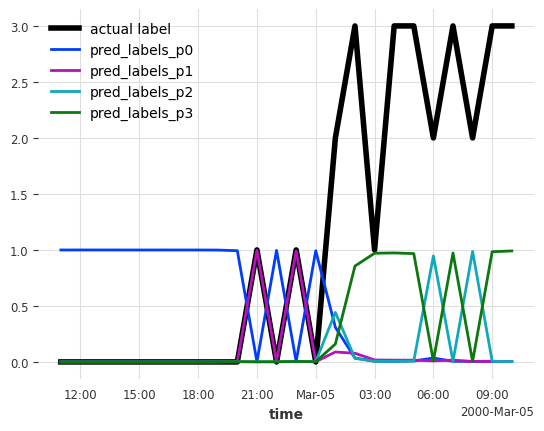

In [11]:
preds_proba = model.historical_forecasts(
    predict_likelihood_parameters=True, **hfc_kwargs
)
labels_test[:24].plot(label="actual label", lw=4)
preds_proba[:24].plot(label="pred")

Computing the metrics also works for probabilistic forecasts. It will compare the actual labels against the label with the highest predicted probability.

In [12]:
cm = model.backtest(
    historical_forecasts=preds_proba,
    metric=metrics.confusion_matrix,
    metric_kwargs={"labels": label_vals},
    **hfc_kwargs,
)
pd.DataFrame(cm, index=cats, columns=cats)

,"high std, trend inc","high std, trend dec","low std, trend inc","low std, trend dec"
"high std, trend inc",267.0,1.0,0.0,0.0
"high std, trend dec",0.0,176.0,0.0,1.0
"low std, trend inc",0.0,0.0,12.0,0.0
"low std, trend dec",0.0,0.0,0.0,20.0


## Classification Models for Forecasting Tasks

While we've demonstrated using classification models for time series labeling (predicting labels for the same time steps as the input features), these models can also be used for traditional forecasting tasks. In forecasting mode, you would predict categorical values for future time steps based on historical data.

The workflow for forecasting with classification models is identical to regression tasks described in the [SKLearn Model examples](https://unit8co.github.io/darts/examples/20-SKLearnModel-examples.html), with the key difference being that we perform classification instead of regression. You would:

1. Use `lags` to specify historical target values as features
2. Optionally include `lags_past_covariates` and `lags_future_covariates` for additional features
3. Set `output_chunk_length` to determine how many future steps to predict at once
4. Use `predict()` to generate forecasts for future time steps

This makes Darts' classification models versatile tools for both labeling and forecasting categorical time series data.